In [4]:
import sys
sys.path.append("../src/data") 

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_builder import FeatureBuilder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Split the data into training, validation, and test sets if not already done
from generate_data_splits import generate_splits
generate_splits()

(1149, 246, 249)

In [7]:
# Load and preprocess the data
train_data = FeatureBuilder(file_path="../data/raw_splits/train_data.csv", normalize=False, exclude_columns=[]).build_features()
val_data = FeatureBuilder(file_path="../data/raw_splits/val_data.csv", normalize=False, exclude_columns=[]).build_features()
test_data = FeatureBuilder(file_path="../data/raw_splits/test_data.csv", normalize=False, exclude_columns=[]).build_features()

# Separate features (X) and labels (y)
X_train = train_data.drop(["id", "label"], axis=1)
y_train = train_data["label"]
X_val = val_data.drop(["id", "label"], axis=1)
y_val = val_data["label"]
X_test = test_data.drop(["id", "label"], axis=1)
y_test = test_data["label"]

d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())


In [8]:
X_train.columns

Index(['q1_processed', 'q2_ingredient_count', 'q2_pizza_prob',
       'q2_shawarma_prob', 'q2_sushi_prob', 'q3_week_day_lunch',
       'q3_week_day_dinner', 'q3_weekend_lunch', 'q3_weekend_dinner',
       'q3_at_a_party', 'q3_late_night_snack', 'q4_processed', 'q5_pizza_prob',
       'q5_shawarma_prob', 'q5_sushi_prob', 'q6_pizza_prob',
       'q6_shawarma_prob', 'q6_sushi_prob', 'q7_parents', 'q7_siblings',
       'q7_friends', 'q7_teachers', 'q7_strangers', 'q8_processed',
       'q1_times_q2', 'q1_times_q4', 'q4_divided_by_q1', 'q2_times_q4',
       'q2_divided_by_q4', 'q4_divided_by_q2', 'q8_divided_by_q2',
       'q8_divided_by_q4'],
      dtype='object')

In [10]:
def plot_hyperparameter_vs_accuracy(
    model_class, 
    hyperparameter_name, 
    hyperparameter_values, 
    X_train, y_train, 
    X_val, y_val, 
    fixed_params=None,
    categorical=False  # Set to True for categorical hyperparameters
):
    """
    Plots the effect of a single hyperparameter on training and validation accuracy.

    Parameters:
        model_class: The model class to use (e.g., RandomForestClassifier).
        hyperparameter_name (str): Name of the hyperparameter (e.g., "n_estimators").
        hyperparameter_values (list): List of values to test for the hyperparameter.
        X_train, y_train: Training data.
        X_val, y_val: Validation data.
        fixed_params (dict): Fixed hyperparameters for the model.
        categorical (bool): Whether the hyperparameter is categorical.
    """
    if fixed_params is None:
        fixed_params = {}

    # Lists to store accuracy values
    train_accuracy = []
    val_accuracy = []

    # Test different values of the hyperparameter
    for value in hyperparameter_values:
        # Initialize the model with the current hyperparameter value
        params = {hyperparameter_name: value, **fixed_params}
        model = model_class(random_state=42, **params)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Record training accuracy
        train_accuracy.append(model.score(X_train, y_train))
        
        # Record validation accuracy
        val_accuracy.append(model.score(X_val, y_val))

    # Plot the results
    plt.figure(figsize=(10, 6))
    
    if categorical:
        # Bar plot for categorical hyperparameters
        x = np.arange(len(hyperparameter_values))
        plt.bar(x - 0.2, train_accuracy, width=0.4, label="Training Accuracy")
        plt.bar(x + 0.2, val_accuracy, width=0.4, label="Validation Accuracy")
        plt.xticks(x, hyperparameter_values)
    else:
        # Line plot for numerical hyperparameters
        plot_values = [value if value is not None else 0 for value in hyperparameter_values]
        plt.plot(plot_values, train_accuracy, label="Training Accuracy", marker="o")
        plt.plot(plot_values, val_accuracy, label="Validation Accuracy", marker="o")
        plt.xticks(plot_values, hyperparameter_values)

    # Find the best value
    best_index = np.argmax(val_accuracy)
    best_value = hyperparameter_values[best_index]
    best_accuracy = val_accuracy[best_index]

    # Highlight the best value
    if categorical:
        plt.axvline(x=best_index, color="red", linestyle="--", label=f"Best {hyperparameter_name} = {best_value} (Val Acc={best_accuracy:.2f})")
    else:
        plot_best_value = best_value if best_value is not None else 0
        plt.axvline(x=plot_best_value, color="red", linestyle="--", label=f"Best {hyperparameter_name} = {best_value} (Val Acc={best_accuracy:.2f})")

    plt.xlabel(hyperparameter_name)
    plt.ylabel("Accuracy")
    plt.title(f"Effect of {hyperparameter_name} on Accuracy ({model_class.__name__})")
    plt.legend()
    plt.grid()
    plt.show()

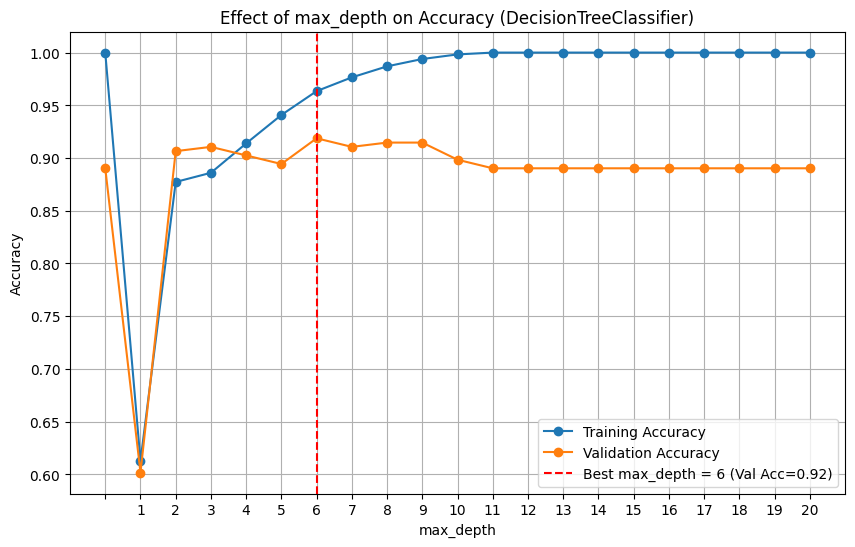

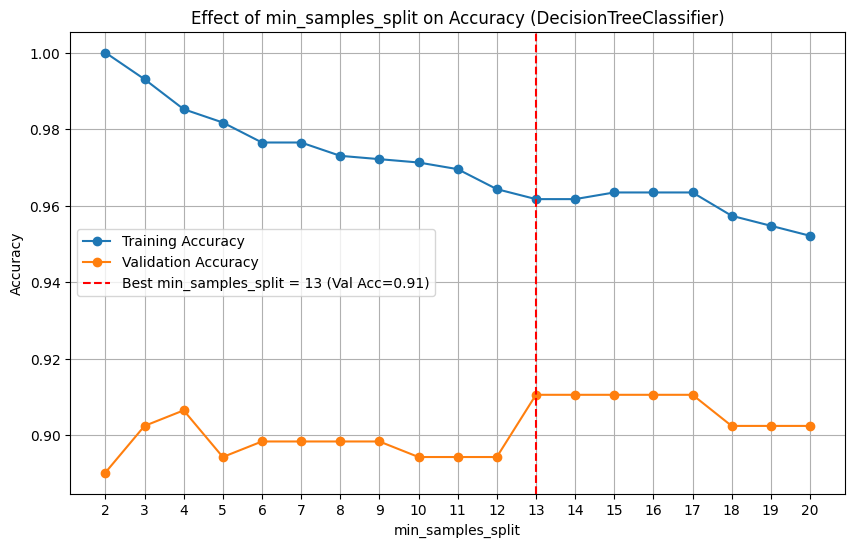

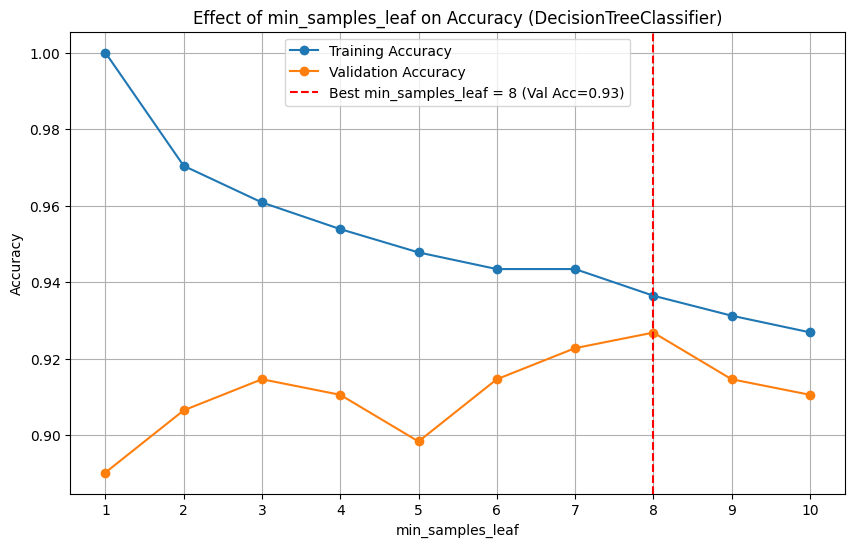

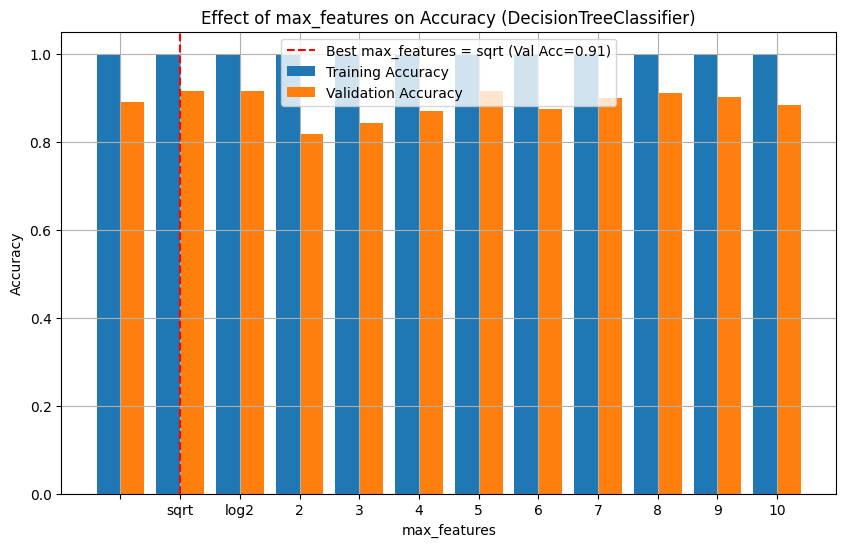

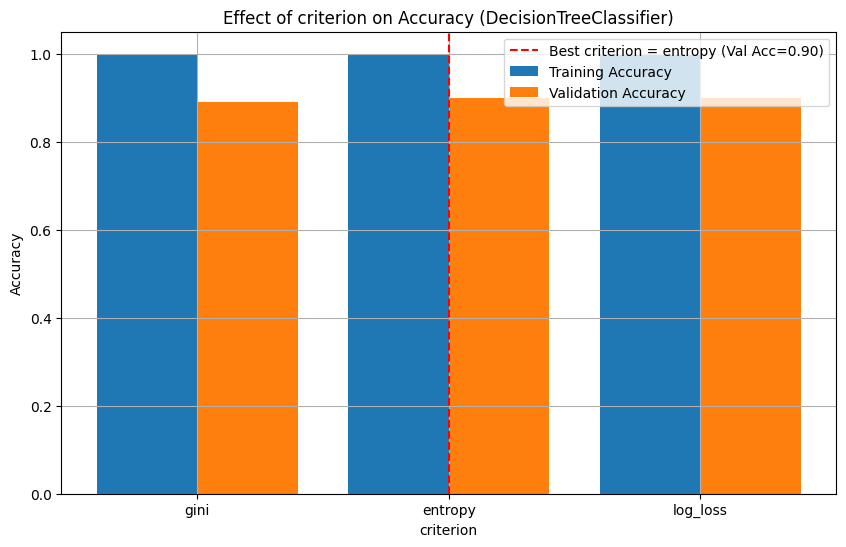

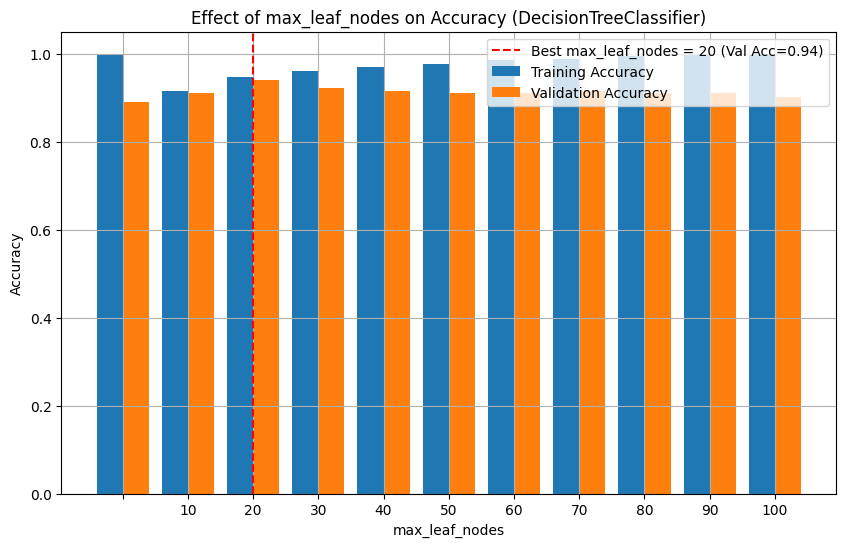

In [12]:
# Step 1
# Use plot_hyperparameter_vs_accuracy to explore the effect of each hyperparameter individually while keeping others at their default values.
# Identify the "interesting" ranges where the model’s performance (e.g., validation accuracy) changes significantly.

plot_hyperparameter_vs_accuracy(
    model_class=DecisionTreeClassifier,
    hyperparameter_name="max_depth",
    hyperparameter_values=[None] + list(range(1, 21)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical=False
)

plot_hyperparameter_vs_accuracy(
    model_class=DecisionTreeClassifier,
    hyperparameter_name="min_samples_split",
    hyperparameter_values=list(range(2, 21)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical=False
)

plot_hyperparameter_vs_accuracy(
    model_class=DecisionTreeClassifier,
    hyperparameter_name="min_samples_leaf",
    hyperparameter_values=list(range(1, 11)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical=False
)

plot_hyperparameter_vs_accuracy(
    model_class=DecisionTreeClassifier,
    hyperparameter_name="max_features",
    # hyperparameter_values=list(range(1, X_train.shape[1] + 1)) + [None, "sqrt", "log2"],
    # hyperparameter_values=list(range(1, X_train.shape[1] + 1)),
    hyperparameter_values=[None, "sqrt", "log2"] + list(range(2, 11)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical=True
)

plot_hyperparameter_vs_accuracy(
    model_class=DecisionTreeClassifier,
    hyperparameter_name="criterion",
    # hyperparameter_values=list(range(1, X_train.shape[1] + 1)) + [None, "sqrt", "log2"],
    # hyperparameter_values=list(range(1, X_train.shape[1] + 1)),
    hyperparameter_values=["gini", "entropy", "log_loss"],
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical=True
)

plot_hyperparameter_vs_accuracy(
    model_class=DecisionTreeClassifier,
    hyperparameter_name="max_leaf_nodes",
    # hyperparameter_values=list(range(1, X_train.shape[1] + 1)) + [None, "sqrt", "log2"],
    # hyperparameter_values=list(range(1, X_train.shape[1] + 1)),
    hyperparameter_values=[None] + list(range(10, 101, 10)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    categorical=True
)

In [13]:
# Step 2
# Use a smaller, focused range of hyperparameter values based on the insights from the visual exploration.
# Perform a grid search with cross-validation to find the best combination of hyperparameters


# Define the parameter grid
param_grid = {
    "max_depth": [None, 6, 12],  # Maximum depth of trees
    "min_samples_split": [8, 11, 15],  # Minimum samples to split a node
    "min_samples_leaf": [3, 6, 9],  # Minimum samples at a leaf node
    "max_features": [None, 4, 9],  # Number of features to consider for splits
    "criterion": ["log_loss", "entropy", "gini"],
    "max_leaf_nodes": [None, 30, 60],
}


# Initialize the Decision Tree model
df = DecisionTreeClassifier(random_state=42)

# Define the GroupKFold object
group_kfold = GroupKFold(n_splits=5)# Data is divided into 5 folds, the model is trained and validated 5 times, each time using a different fold as the validation set and the remaining folds as the training set

# Perform grid search with GroupKFold
grid_search = GridSearchCV(df, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1)

# Combine training and validation data
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])
groups_final = pd.concat([train_data["id"], val_data["id"]])

# Fit the grid search with groups
grid_search.fit(X_train_final, y_train_final, groups=groups_final)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

# Evaluate best model on test set
test_predictions = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("Test Classification Report:\n", classification_report(y_test, test_predictions))

Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 9, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 8}
Best Validation Accuracy: 0.9096774193548388
Test Accuracy: 0.8835341365461847
Test Classification Report:
               precision    recall  f1-score   support

       pizza       0.93      0.81      0.86        83
    shawarma       0.83      0.93      0.88        83
       sushi       0.90      0.92      0.91        83

    accuracy                           0.88       249
   macro avg       0.89      0.88      0.88       249
weighted avg       0.89      0.88      0.88       249



C:\Users\Aamid Mohsin\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


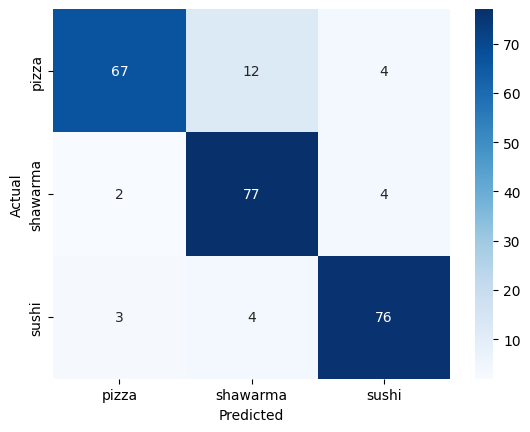

In [15]:
class_names = ["pizza", "shawarma", "sushi"]  
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig("confusion_decision_tree.png")
plt.show()

                Feature  Importance
13     q5_shawarma_prob    0.355547
17        q6_sushi_prob    0.207433
9         q3_at_a_party    0.175712
14        q5_sushi_prob    0.085887
12        q5_pizza_prob    0.069332
16     q6_shawarma_prob    0.025598
11         q4_processed    0.015965
23         q8_processed    0.012840
28     q2_divided_by_q4    0.010656
25          q1_times_q4    0.010504
2         q2_pizza_prob    0.006662
20           q7_friends    0.006624
5     q3_week_day_lunch    0.004957
30     q8_divided_by_q2    0.003459
24          q1_times_q2    0.003385
15        q6_pizza_prob    0.003288
31     q8_divided_by_q4    0.001481
1   q2_ingredient_count    0.000670
18           q7_parents    0.000000
19          q7_siblings    0.000000
10  q3_late_night_snack    0.000000
21          q7_teachers    0.000000
22         q7_strangers    0.000000
8     q3_weekend_dinner    0.000000
7      q3_weekend_lunch    0.000000
6    q3_week_day_dinner    0.000000
26     q4_divided_by_q1    0

<Axes: >

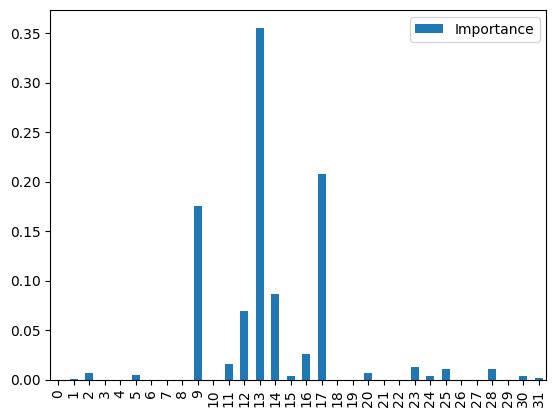

In [16]:
# Specific for trees only
importances = grid_search.best_estimator_.feature_importances_
feature_names = X_train_final.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
print(feature_importance_df.sort_values(by="Importance", ascending=False))
feature_importance_df.plot(kind='bar')

Notes / Observations / Thoughts:
- All the tested hyperparameters have a significant effect on test and validation accuracy except for: `splitter`, `criterion`, and `max_features`.
    - Increasing `max_depth` will increase validation and training accuracy, however it will overfit past `max_depth = 9`
    - Increasing `min_samples_split` will steadily decrease training accuracy, while maintaining a validation accuracy of approximately 0.90 at high values.
    - Increasing `min_samples_leaf` will exponentially decrease training accuracy, but stabilize around 0.94. Validation accuracy oscillates between 0.86 and 0.90
    - For `splitter`, `criterion` and `max_features`